In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulate as sim
import EKF_class as EKF
from scipy.spatial.transform import Rotation as Rot

## Parameters 

In [2]:
del_t = 0.1 #time step
omega = .01 # rad/s rotation of debris arounbd y
occlusions = 3 #how many occlusions


## Initialize Simulation

In [3]:
#starting with an [r,t,n] 
center_of_mass = np.array([[0,0,0]]).T
orbit_radius = 10

sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nx0 = sat1_x0/np.linalg.norm(sat1_x0)
sat1_v = 3 #u/s
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1]))

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nx0 = sat2_x0/np.linalg.norm(sat2_x0)
sat2_v = 3 #u/s
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1]))

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nx0 = sat3_x0/np.linalg.norm(sat3_x0)
sat3_v = 3 #u/s
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0]))


n_orbits = 1
t = np.arange(0, n_orbits*2*np.pi, del_t)

x1 = center_of_mass + orbit_radius * np.sin(t) * sat1_nv0 + orbit_radius * np.cos(t) * sat1_nx0
x2 = center_of_mass + orbit_radius * np.sin(t) * sat2_nv0 + orbit_radius * np.cos(t) * sat2_nx0
x3 = center_of_mass + orbit_radius * np.sin(t) * sat3_nv0 + orbit_radius * np.cos(t) * sat3_nx0



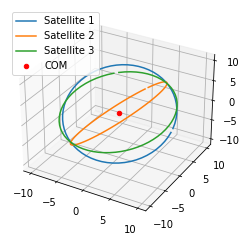

In [4]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0,color='r',label="COM")

ax.plot(x1[0,:],x1[1,:],x1[2,:], label='Satellite 1')
ax.plot(x2[0,:],x2[1,:],x2[2,:], label='Satellite 2')
ax.plot(x3[0,:],x3[1,:],x3[2,:], label='Satellite 3')
ax.legend()
#ax.axis("equal")

plt.show()


In [5]:
orbit_radius = 10
sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1])).T

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1])).T

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0])).T

# Initialize 3 Observer Satellites
o1 = sim.observer(sat1_x0,sat1_nv0, del_t)
o2 = sim.observer(sat2_x0,sat2_nv0, del_t)
o3 = sim.observer(sat3_x0,sat3_nv0, del_t)

In [6]:
debris_points = np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1],[3,0,1],[3,0,-1],[-2,0,-1]]).T

    
    # Initialize the Quaternion for Debris Rotation. 
    # Given any normalized direction vector [nx,ny,nz] and angular rotation [omega], the quaternion is of the 
    # form: [nx*sin(omega/2),ny*sin(omega/2),nz*sin(omega/2),cos(omega/2)]

quat = np.array([0,1*np.sin(omega/2),0,np.cos(omega/2)])

# Initialize the Debris Object
deb = sim.debris(debris_points,quat, del_t)
mtest = sim.MeasurementModel(deb,np.array([o1,o2,o3]),del_t, occlusions, 0.00001*np.eye(len(debris_points[0]))) #signal to noise ration = 10

## EKF

In [7]:
#Initialize
n = 36 #Dimension State Space
mu0 = np.zeros((n))
mu0[:3] = np.array([0.0, omega, 0.0])
mu0[3:] = debris_points.T.flatten()
sigma0 = 100* np.diag(np.ones((n)))

kalman_filter = EKF.KalmanFilter(mu0, sigma0, del_t)

In [8]:
#Estimate
sim_time = 1200
t1 = np.linspace(0,sim_time, int(sim_time/del_t))

P_est_hist = np.zeros((len(t1), n, n))
x_est_hist = np.zeros((len(t1), n))
x_est_hist_min = np.zeros((len(t1), n))
for i in range(0,len(t1)):
    y = mtest[i] 
    sat_pos = o1[i].flatten()


    x_est_min, P_est= kalman_filter.predict()
    x_est, P_est = kalman_filter.update(y[0], x_est_min, P_est, sat_pos)
  
    # Make sure to store the estimated state and covariance for analysis
    P_est_hist[i, :, :] = P_est
    x_est_hist[i, :] = x_est
    x_est_hist_min[i, :] = x_est_min

## Reference Truth

In [9]:
time_step = del_t
time_array = np.arange(0, sim_time, time_step)
posehist = np.zeros((36, len(time_array)))

for t in range(0, len(time_array)):
    posehist[3:, t] = deb[t].T.flatten()

posehist = posehist.T

## Check Noise Level

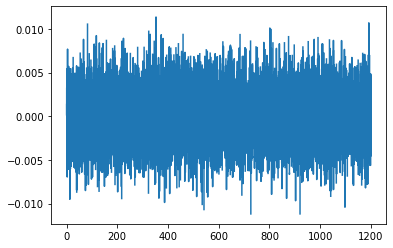

In [10]:

measur = np.zeros((len(time_array), 11))
sat = np.zeros((len(time_array), 3))
for i in range(0, len(time_array)):
    measur[i] = mtest[i][0]
    sat[i]  =  o1[i].flatten()

plt.figure()
#plt.plot(time_array, measur[:, 0])
#plt.plot(time_array, np.linalg.norm(posehist[:, 3:6] - sat, axis = 1))
plt.plot(time_array, np.linalg.norm(posehist[:, 3:6] - sat, axis = 1)-measur[:, 0])



## Results Angular Velocity

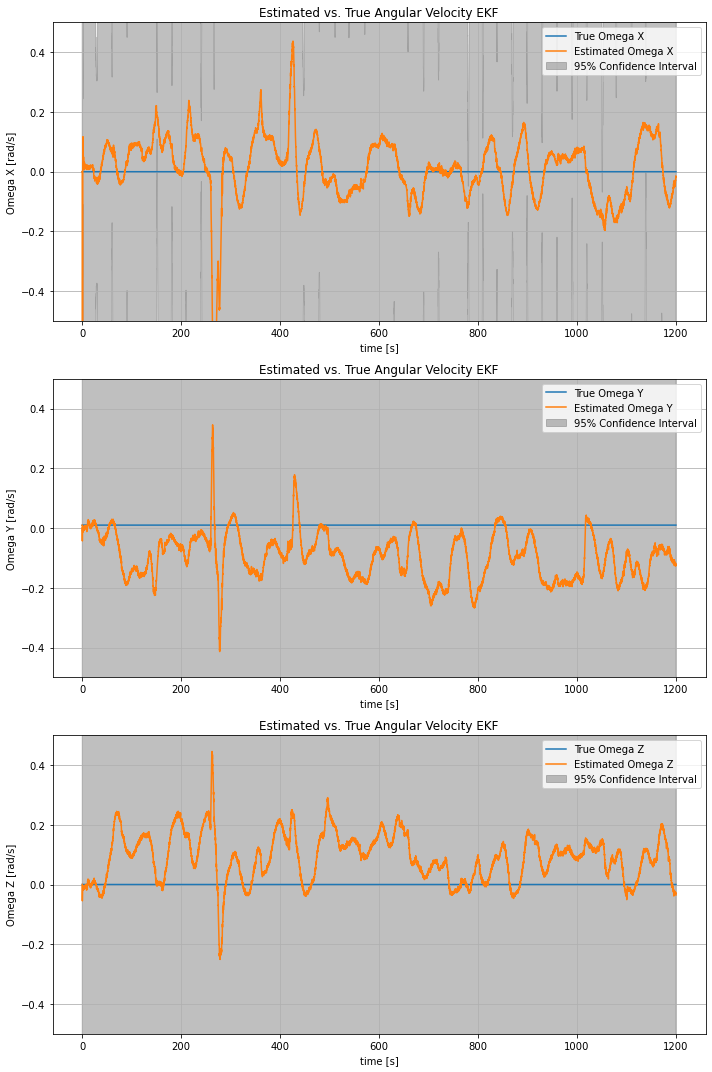

In [11]:
time_step = del_t
time_array = np.arange(0, sim_time, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 5, 5])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 3, 3])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 4, 4])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array,  np.zeros(len(time_array)), label="True Omega X")
axs[0].plot(time_array, x_est_hist[:, 0], label="Estimated Omega X")
axs[0].fill_between(time_array, x_est_hist[:, 0] - confidence_interval_x, x_est_hist[:, 0] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('Omega X [rad/s]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim([-0.5, 0.5])
axs[0].set_title('Estimated vs. True Angular Velocity EKF')

# Plot Y Position
axs[1].plot(time_array, omega * np.ones(len(time_array)), label="True Omega Y")
axs[1].plot(time_array, x_est_hist_min[:, 1], label="Estimated Omega Y")
axs[1].fill_between(time_array,  x_est_hist[:, 1] - confidence_interval_y, x_est_hist[:, 1] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Omega Y [rad/s]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim([-0.5, 0.5])
axs[1].set_title('Estimated vs. True Angular Velocity EKF')

axs[2].plot(time_array,  np.zeros(len(time_array)), label="True Omega Z")
axs[2].plot(time_array, x_est_hist[:, 2], label="Estimated Omega Z")
axs[2].fill_between(time_array, x_est_hist[:, 2] - confidence_interval_heading, x_est_hist[:, 2] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Omega Z [rad/s]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Angular Velocity EKF')
axs[2].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.show()




## Results for an Arbitrary Point

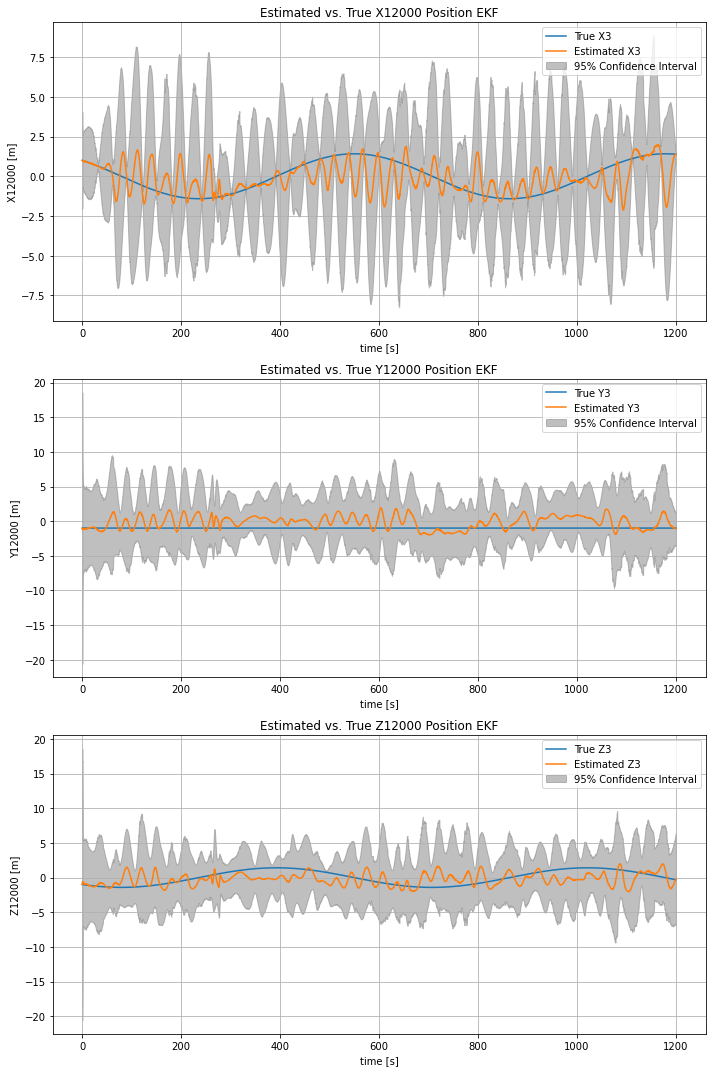

In [12]:
point = 3
time_step = del_t
time_array = np.arange(0, sim_time, time_step)


x_index = 3 + point * 3
y_index = 4 + point * 3
z_index = 5 + point * 3

# Calculate confidence intervals
std_dev_x = np.sqrt(P_est_hist[:, x_index, x_index])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, y_index, y_index])
confidence_interval_y = 1.96 * std_dev_y

std_dev_z = np.sqrt(P_est_hist[:, z_index, z_index])
confidence_interval_z = 1.96 * std_dev_z # 95%

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
# Plot X Position
axs[0].plot(time_array, posehist[:, x_index], label=f"True X{point}")
axs[0].plot(time_array, x_est_hist[:, x_index], label=f"Estimated X{point}")
axs[0].fill_between(time_array, x_est_hist[:, x_index] - confidence_interval_x, x_est_hist[:, x_index] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel(f'X{i+1} [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title(f'Estimated vs. True X{i+1} Position EKF')

# Plot Y Position
axs[1].plot(time_array, posehist[:, y_index], label=f"True Y{point}")
axs[1].plot(time_array, x_est_hist[:, y_index], label=f"Estimated Y{point}")
axs[1].fill_between(time_array, x_est_hist[:, y_index] - confidence_interval_y, x_est_hist[:, y_index] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel(f'Y{i+1} [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title(f'Estimated vs. True Y{i+1} Position EKF')

# Plot Z Position
axs[2].plot(time_array, posehist[:, z_index], label=f"True Z{point}")
axs[2].plot(time_array, x_est_hist[:, z_index], label=f"Estimated Z{point}")
axs[2].fill_between(time_array, x_est_hist[:, z_index] - confidence_interval_z, x_est_hist[:, z_index] + confidence_interval_z, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel(f'Z{i+1} [m]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title(f'Estimated vs. True Z{i+1} Position EKF')


plt.tight_layout()
plt.show()


fig.savefig("position of point noiseless.png", dpi=300, bbox_inches="tight")

## Plot all Points

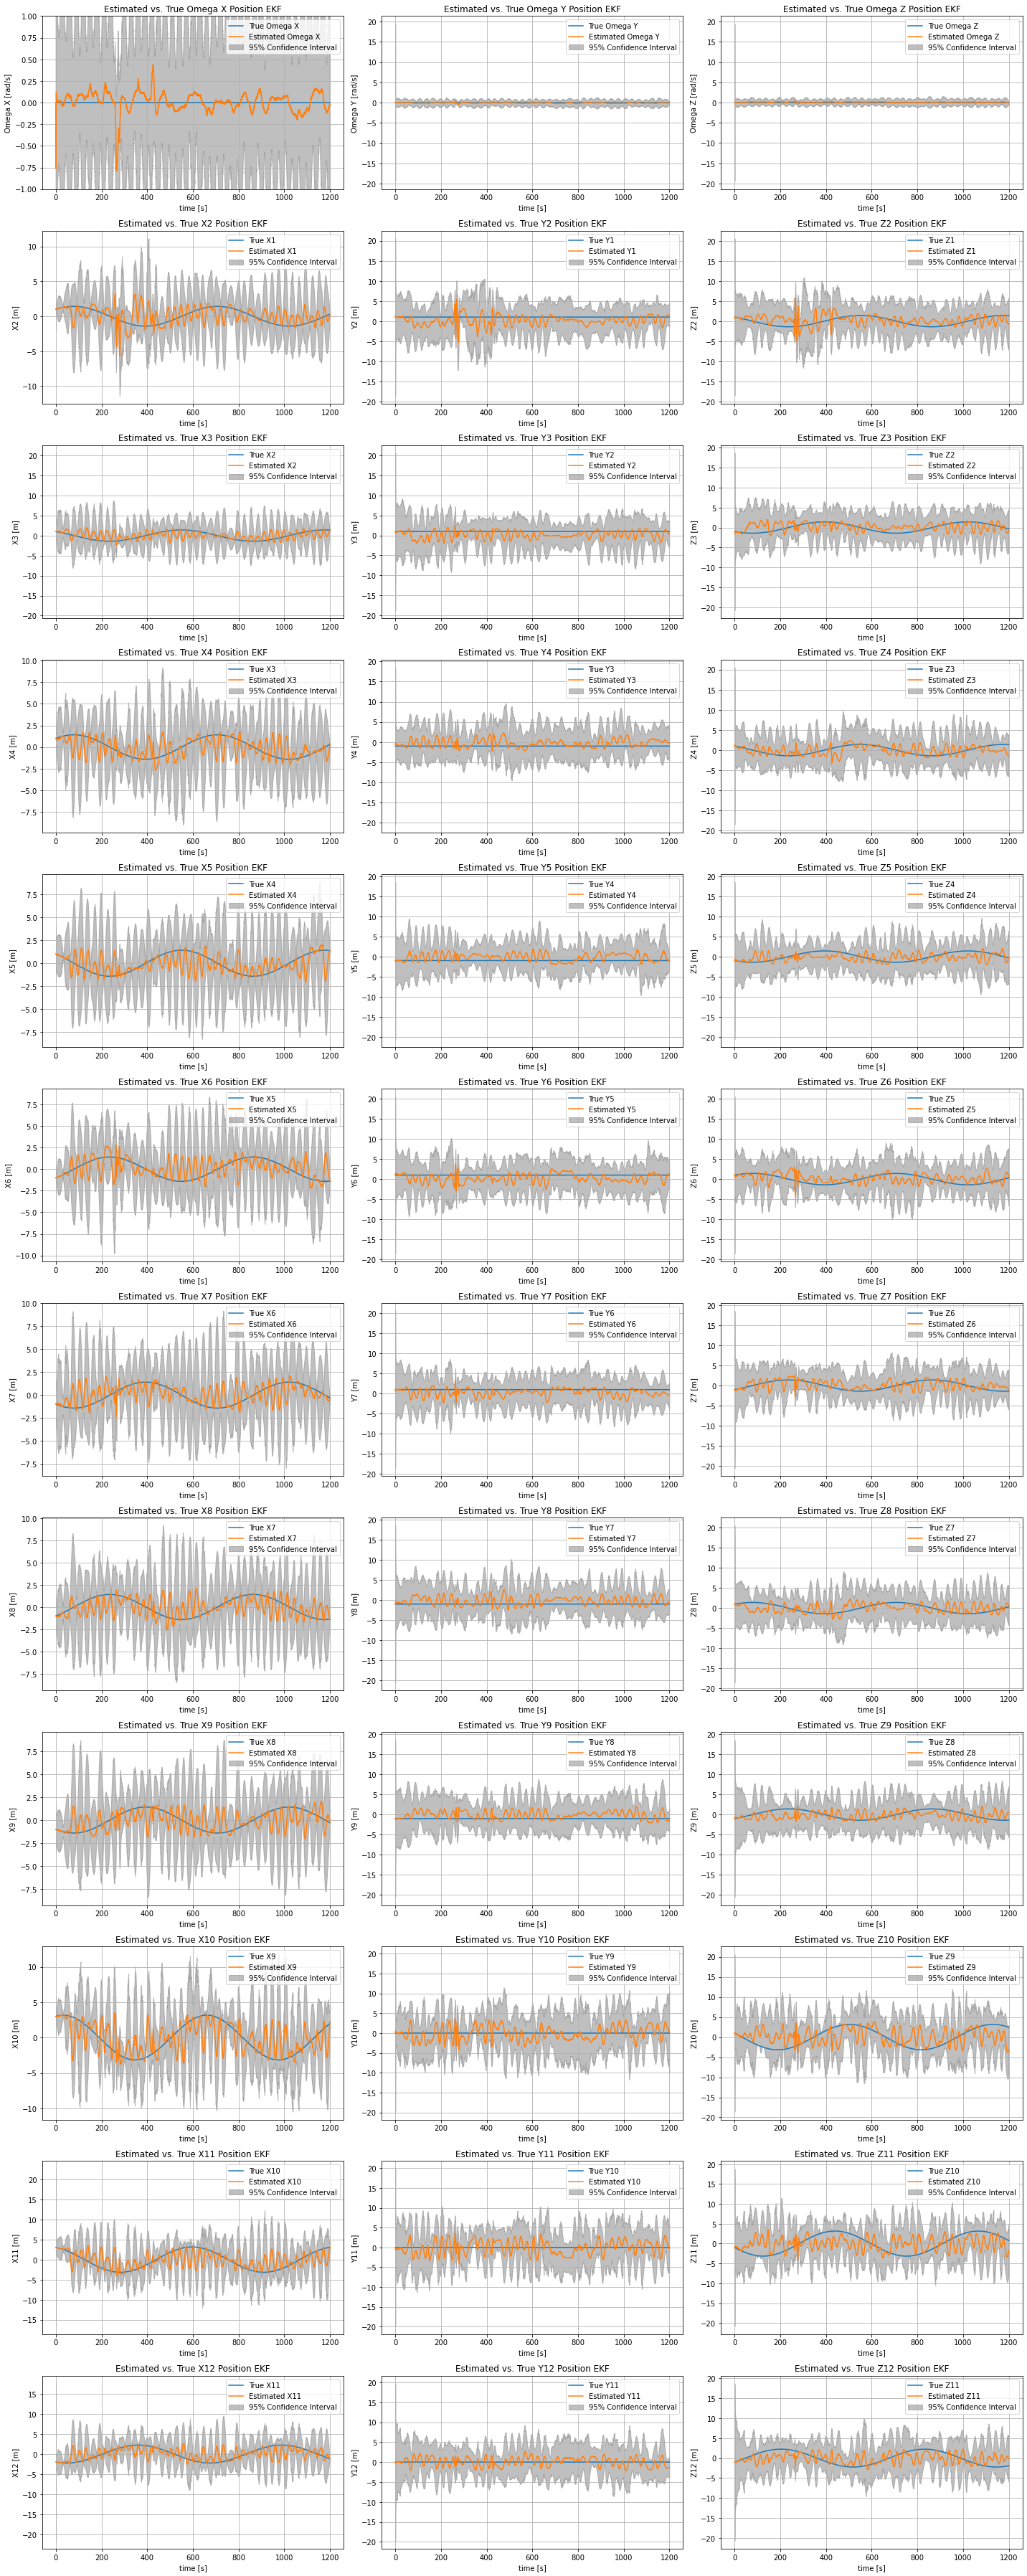

In [13]:


time_step = del_t
time_array = np.arange(0, sim_time, time_step)

fig, axs = plt.subplots(12, 3, figsize=(20, 50))

# Plot Angular Velocity
x_index = 0
y_index = 1
z_index = 2

# Calculate confidence intervals
std_dev_x = np.sqrt(P_est_hist[:, x_index, x_index])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, y_index, y_index])
confidence_interval_y = 1.96 * std_dev_y

std_dev_z = np.sqrt(P_est_hist[:, z_index, z_index])
confidence_interval_z = 1.96 * std_dev_z # 95%

# Plot X Velocity
axs[0, 0].plot(time_array, posehist[:, x_index], label=f"True Omega X")
axs[0, 0].plot(time_array, x_est_hist[:, x_index], label=f"Estimated Omega X")
axs[0, 0].fill_between(time_array, x_est_hist[:, x_index] - confidence_interval_x, x_est_hist[:, x_index] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0, 0].set_xlabel('time [s]')
axs[0, 0].set_ylabel('Omega X [rad/s]')
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Estimated vs. True Omega X Position EKF')

# Plot Y Velocity
axs[0, 1].plot(time_array, posehist[:, y_index], label=f"True Omega Y")
axs[0, 1].plot(time_array, x_est_hist[:, y_index], label=f"Estimated Omega Y")
axs[0, 1].fill_between(time_array, x_est_hist[:, y_index] - confidence_interval_y, x_est_hist[:, y_index] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0, 1].set_xlabel('time [s]')
axs[0, 1].set_ylabel('Omega Y [rad/s]')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Estimated vs. True Omega Y Position EKF')

# Plot Z Velocity
axs[0, 2].plot(time_array, posehist[:, z_index], label=f"True Omega Z")
axs[0, 2].plot(time_array, x_est_hist[:, z_index], label=f"Estimated Omega Z")
axs[0, 2].fill_between(time_array, x_est_hist[:, z_index] - confidence_interval_z, x_est_hist[:, z_index] + confidence_interval_z, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0, 2].set_xlabel('time [s]')
axs[0, 2].set_ylabel('Omega Z [rad/s]')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_title('Estimated vs. True Omega Z Position EKF')


for i in range(1,12):
    x_index = i * 3
    y_index = 1 + i * 3
    z_index = 2 + i * 3

    # Calculate confidence intervals
    std_dev_x = np.sqrt(P_est_hist[:, x_index, x_index])
    confidence_interval_x = 1.96 * std_dev_x

    std_dev_y = np.sqrt(P_est_hist[:, y_index, y_index])
    confidence_interval_y = 1.96 * std_dev_y

    std_dev_z = np.sqrt(P_est_hist[:, z_index, z_index])
    confidence_interval_z = 1.96 * std_dev_z # 95%
    
    # Plot X Position
    axs[i, 0].plot(time_array, posehist[:, x_index], label=f"True X{i}")
    axs[i, 0].plot(time_array, x_est_hist[:, x_index], label=f"Estimated X{i}")
    axs[i, 0].fill_between(time_array, x_est_hist[:, x_index] - confidence_interval_x, x_est_hist[:, x_index] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
    axs[i, 0].set_xlabel('time [s]')
    axs[i, 0].set_ylabel(f'X{i+1} [m]')
    axs[i, 0].legend()
    axs[i, 0].grid(True)
    axs[i, 0].set_title(f'Estimated vs. True X{i+1} Position EKF')

    # Plot Y Position
    axs[i, 1].plot(time_array, posehist[:, y_index], label=f"True Y{i}")
    axs[i, 1].plot(time_array, x_est_hist[:, y_index], label=f"Estimated Y{i}")
    axs[i, 1].fill_between(time_array, x_est_hist[:, y_index] - confidence_interval_y, x_est_hist[:, y_index] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
    axs[i, 1].set_xlabel('time [s]')
    axs[i, 1].set_ylabel(f'Y{i+1} [m]')
    axs[i, 1].legend()
    axs[i, 1].grid(True)
    axs[i, 1].set_title(f'Estimated vs. True Y{i+1} Position EKF')

    # Plot Z Position
    axs[i, 2].plot(time_array, posehist[:, z_index], label=f"True Z{i}")
    axs[i, 2].plot(time_array, x_est_hist[:, z_index], label=f"Estimated Z{i}")
    axs[i, 2].fill_between(time_array, x_est_hist[:, z_index] - confidence_interval_z, x_est_hist[:, z_index] + confidence_interval_z, color='gray', alpha=0.5, label="95% Confidence Interval")
    axs[i, 2].set_xlabel('time [s]')
    axs[i, 2].set_ylabel(f'Z{i+1} [m]')
    axs[i, 2].legend()
    axs[i, 2].grid(True)
    axs[i, 2].set_title(f'Estimated vs. True Z{i+1} Position EKF')

plt.tight_layout()
plt.show()

fig.savefig("position_of_points noiseless.png", dpi=300, bbox_inches="tight")


## Get Attitude

In [20]:
## Ground Truth
euler_gt = np.zeros((len(time_array), 3))
euler_gt[:, 0] = np.rad2deg(omega*time_array)

In [21]:
def get_Rot_transl(grtr, transf): #grtr only involves the points that were matched
  #find centroids
  N1 = np.shape(grtr)[0]

  rc_grtr = 1/N1 * np.sum(grtr, axis=0)

  N2 = np.shape(transf)[0]
  rc_transf = 1/N2 * np.sum(transf, axis = 0) #rc hat

  #find H
  r_grtr = grtr - rc_grtr #ri - rc
  r_transf = transf - rc_transf #ri hat - rc hat
  H = np.zeros((3,3))
  for i in range(0, N2):
    H += np.outer(r_transf[i,:], r_grtr[i, :])


  #find R and tau
  U, Sigma, Vt = np.linalg.svd(H)
  R = Vt.T @ U.T

  tau = (rc_grtr - R @ rc_transf)


  # homogeneous transformation
  T = np.identity(4)
  T[:3, :3] = R
  T[:3, 3] = tau

  return R, tau

In [17]:
#Attitude Error
def get_attitude_error(R1, R2):
    R_rel = np.dot(R2, R1.T)

    angles = Rot.from_matrix(R_rel).as_euler('yxz', degrees=True)
    return angles

In [24]:
euler = np.zeros((len(t1), 3))
COM = np.zeros((len(t1), 3))

euler_error = np.zeros((len(t1), 3))
COM_error = np.zeros((len(t1), 3))

for i in range(len(t1)):
    R, tau = get_Rot_transl(debris_points.T, x_est_hist[i, 3:].reshape(-1, 3))
    COM[i, :] = tau
    r = Rot.from_matrix(R)
    euler[i, :] = r.as_euler('yxz', degrees=True)
    r_true = Rot.from_euler('yxz', euler_gt[i], degrees=True).as_matrix()
    euler_error[i, :] = get_attitude_error(r_true, R)

    COM_error[i, :] = np.array([0, 0, 0]) - tau




## Plot Attitude

Text(0.5, 1.0, 'Estimated vs. True Yaw EKF')

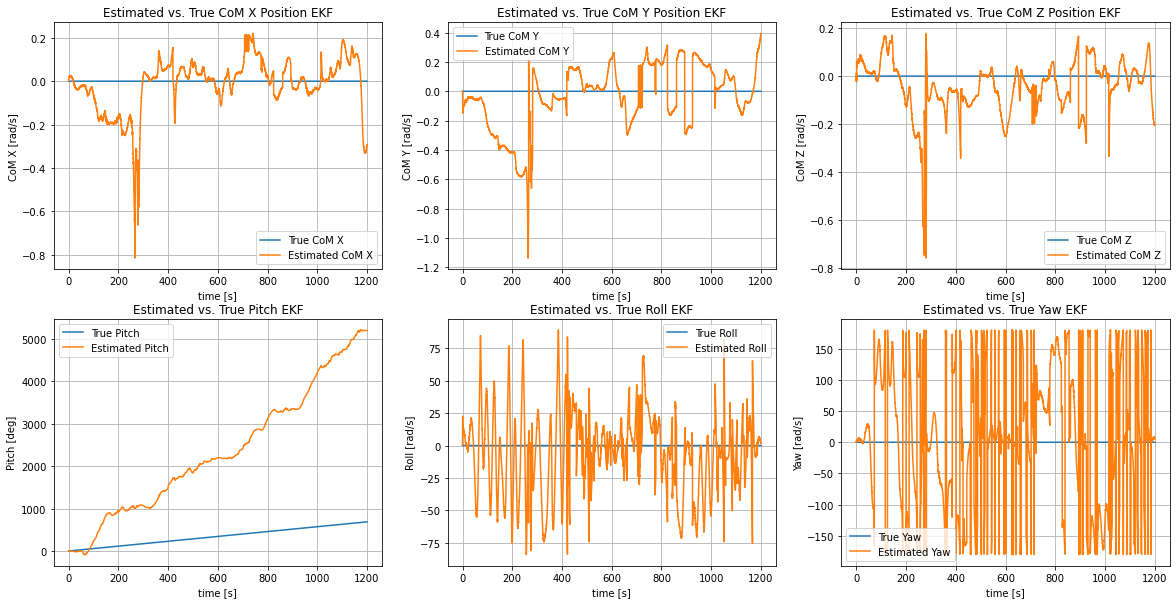

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))


x_index = 0
y_index = 1
z_index = 2

# Calculate confidence intervals
std_dev_x = np.sqrt(P_est_hist[:, x_index, x_index])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, y_index, y_index])
confidence_interval_y = 1.96 * std_dev_y

std_dev_z = np.sqrt(P_est_hist[:, z_index, z_index])
confidence_interval_z = 1.96 * std_dev_z # 95%

# Plot COM Position - expect to be zero
axs[0, 0].plot(time_array, np.zeros(len(time_array)), label=f"True CoM X")
axs[0, 0].plot(time_array, COM[:, x_index], label=f"Estimated CoM X")
axs[0, 0].set_xlabel('time [s]')
axs[0, 0].set_ylabel('CoM X [rad/s]')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Estimated vs. True CoM X Position EKF')

# Plot COM Position - expect to be zero
axs[0, 1].plot(time_array, np.zeros(len(time_array)), label=f"True CoM Y")
axs[0, 1].plot(time_array, COM[:, y_index], label=f"Estimated CoM Y")
axs[0, 1].set_xlabel('time [s]')
axs[0, 1].set_ylabel('CoM Y [rad/s]')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Estimated vs. True CoM Y Position EKF')

# Plot COM Position - expect to be zero
axs[0, 2].plot(time_array, np.zeros(len(time_array)), label=f"True CoM Z")
axs[0, 2].plot(time_array, COM[:, z_index], label=f"Estimated CoM Z")
axs[0, 2].set_xlabel('time [s]')
axs[0, 2].set_ylabel('CoM Z [rad/s]')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_title('Estimated vs. True CoM Z Position EKF')

# Plot Attitude Pitch expect derivative = omega
axs[1, 0].plot(time_array, np.rad2deg(omega*time_array), label=f"True Pitch")
axs[1, 0].plot(time_array, np.unwrap(euler[:, x_index]), label="Estimated Pitch")
axs[1, 0].set_xlabel('time [s]')
axs[1, 0].set_ylabel('Pitch [deg]')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_title('Estimated vs. True Pitch EKF')

# Plot Attitude Roll expect zero
axs[1, 1].plot(time_array, np.zeros(len(time_array)), label=f"True Roll")
axs[1, 1].plot(time_array, euler[:, y_index], label="Estimated Roll")
axs[1, 1].set_xlabel('time [s]')
axs[1, 1].set_ylabel('Roll [rad/s]')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_title('Estimated vs. True Roll EKF')

# Plot Attitude Yaw expect zero
axs[1, 2].plot(time_array, np.zeros(len(time_array)), label=f"True Yaw")
axs[1, 2].plot(time_array, euler[:, z_index], label="Estimated Yaw")
axs[1, 2].set_xlabel('time [s]')
axs[1, 2].set_ylabel('Yaw [rad/s]')
axs[1, 2].legend()
axs[1, 2].grid(True)
axs[1, 2].set_title('Estimated vs. True Yaw EKF')

## Plot Attitude Error

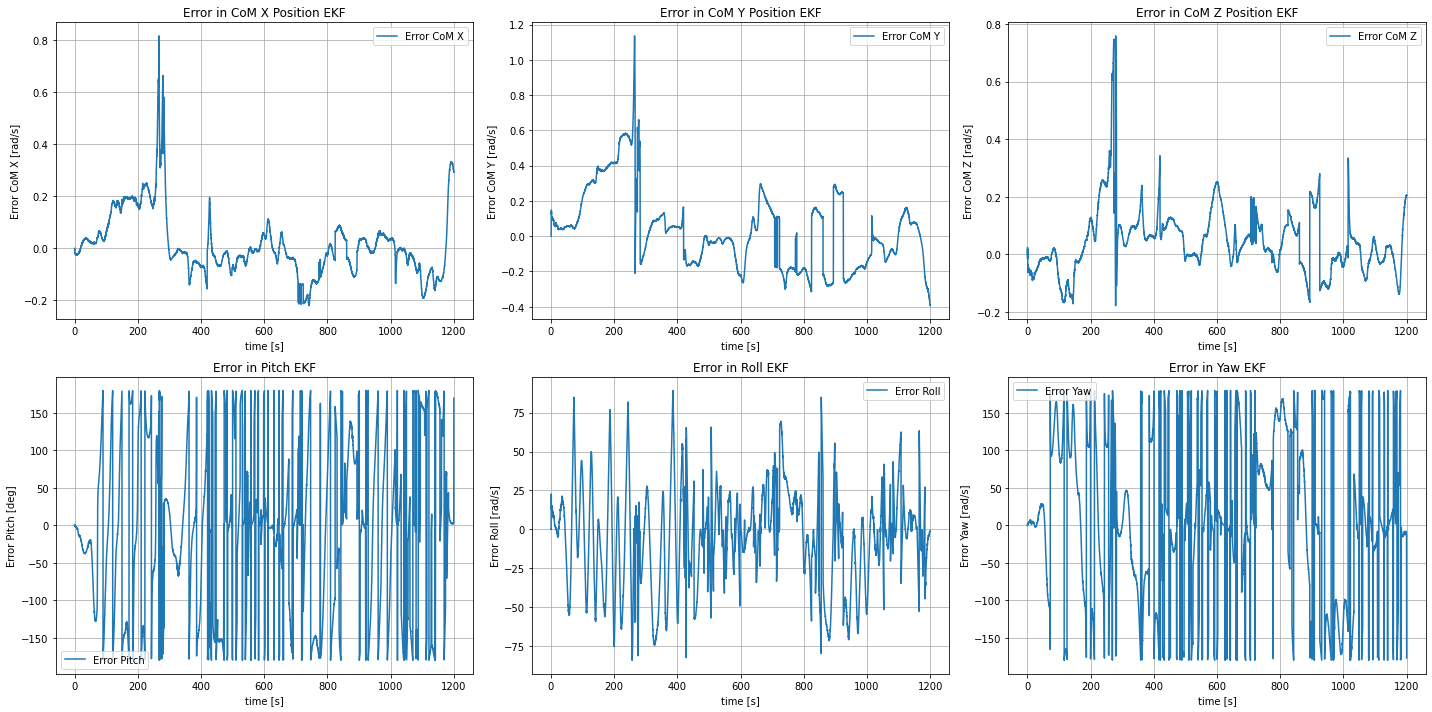

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

x_index = 0
y_index = 1
z_index = 2

# Calculate confidence intervals
std_dev_x = np.sqrt(P_est_hist[:, x_index, x_index])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, y_index, y_index])
confidence_interval_y = 1.96 * std_dev_y

std_dev_z = np.sqrt(P_est_hist[:, z_index, z_index])
confidence_interval_z = 1.96 * std_dev_z # 95%


# Plot CoM Position Error
axs[0, 0].plot(time_array, COM_error[:, 0], label="Error CoM X")
axs[0, 0].set_xlabel('time [s]')
axs[0, 0].set_ylabel('Error CoM X [rad/s]')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Error in CoM X Position EKF')

axs[0, 1].plot(time_array, COM_error[:, 1], label="Error CoM Y")
axs[0, 1].set_xlabel('time [s]')
axs[0, 1].set_ylabel('Error CoM Y [rad/s]')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Error in CoM Y Position EKF')

axs[0, 2].plot(time_array, COM_error[:, 2], label="Error CoM Z")
axs[0, 2].set_xlabel('time [s]')
axs[0, 2].set_ylabel('Error CoM Z [rad/s]')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_title('Error in CoM Z Position EKF')

# Plot Attitude Error
axs[1, 0].plot(time_array, euler_error[:, 0], label="Error Pitch")
axs[1, 0].set_xlabel('time [s]')
axs[1, 0].set_ylabel('Error Pitch [deg]')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_title('Error in Pitch EKF')

axs[1, 1].plot(time_array, euler_error[:, 1], label="Error Roll")
axs[1, 1].set_xlabel('time [s]')
axs[1, 1].set_ylabel('Error Roll [rad/s]')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_title('Error in Roll EKF')

axs[1, 2].plot(time_array, euler_error[:, 2], label="Error Yaw")
axs[1, 2].set_xlabel('time [s]')
axs[1, 2].set_ylabel('Error Yaw [rad/s]')
axs[1, 2].legend()
axs[1, 2].grid(True)
axs[1, 2].set_title('Error in Yaw EKF')

plt.tight_layout()
plt.show()
